In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Mô tả bài toán
Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người có thể đặt câu hỏi và kết nối với những người khác. Một thách thức lớn là loại bỏ những câu hỏi thiếu chân thành - những câu hỏi được đặt ra nhằm mục địch gây tranh cãi, nội dung độc hại hoặc có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích. Quora muốn giải quyết vấn đề này để giữ cho nền tảng của họ trở thành một nơi mà người dùng có thể cảm thấy an toàn khi chia sẻ kiến thức.
* Mục tiêu: Phân loại câu hỏi Sincere và Insincere trên Quora
* Input: Câu hỏi dạng text
* Output: 0/1 (Sincere/ Insincere)

# Phân tích dữ liệu

In [ ]:
train_data = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
test_data = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')

In [ ]:
train_data

In [ ]:
train_data.info()

In [ ]:
test_data

In [ ]:
test_data.info()

**Nhận xét:** Tập dữ liệu không có giá trị null

**File train** gồm: 
* 1306122 dòng x 3 cột (qid, question_text, target)

**File test** gồm: 
* 375806 dòng x 2 cột (qid, question_text)

**Chú thích**
* qid: id của câu hỏi
* question_text: nội dung câu hỏi
* target: phân loại câu hỏi, target = 0 là câu hỏi Sincere, target = 1 là câu hỏi Insincere

In [ ]:
train_data['target'].value_counts()

**Nhận xét**
* Có 1,225,312 câu hỏi target bằng 0, tương ứng là các câu hỏi Sincere.
* Có 80,810 câu hỏi target bằng 1, tương ứng là các câu hỏi Insincere.

In [ ]:
# Pie chart biểu diễn tỉ lệ câu hỏi
toxic_question = train_data[train_data.target == 1]
non_toxic_question = train_data[train_data.target == 0]

label = 'Toxic', 'Non-toxic'
size = [(toxic_question.shape[0] / train_data.shape[0]) * 100, (non_toxic_question.shape[0] / train_data.shape[0]) * 100]
plt.pie(size,labels = label,colors=["m", "c"], autopct="%.2f%%")
plt.axis('equal')
plt.show()

**Nhận xét**
* Dựa vào biểu đồ trên ta có thể thấy rằng có **6.19%** câu hỏi được đánh **nhãn 1** và **93.81%** câu hỏi đánh **nhãn 0**.
* Dữ liệu đang mất cân bằng, với tỉ lệ này, accuracy có thể rất cao mà không cần dùng tới mô hình (khi đoán toàn bộ nhãn là 0, accuracy lên tới gần 94%).\
=> Chọn **F1-score** làm chỉ số đánh giá mô hình.

![](https://miro.medium.com/max/954/1*2dfEH04P9wffwMYjKP5hUg.png)

# Xử lý mất cân bằng dữ liệu
Dùng Under Sampling để giảm số lượng câu Sincere giúp dữ liệu cân bằng hơn
* Ưu điểm: làm cân bằng mẫu một cách nhanh chóng, dễ dàng tiến hành thực hiện mà không cần đến thuật toán giả lập mẫu.
* Nhược điểm: kích thước mẫu sẽ bị giảm đáng kể. 

In [ ]:
#train_data_US = pd.concat([resample(non_toxic_question, replace = True, n_samples = len(toxic_question)*4), toxic_question])
#train_data_US

# Sau khi giảm số lượng câu xuống tỉ lệ 4 câu Sincere:1 câu Insincere thì score thấp hơn do mất nhiều dữ liệu khiến mô hình dự đoán thiếu chính xác.

In [ ]:
y = train_data['target']
y.value_counts().plot(kind='bar', rot=0)

# Tiền xử lý
* Chuyển về dạng viết thường
* Xóa ký hiệu đặc biệt
* Tách các từ
* Loại bỏ stopwords
* Chia tập dữ liệu
* Text Vectorization

In [ ]:
nltk.download('stopwords', 'punkt')
sw = stopwords.words('english')
sw.remove('not')
print(sw)

In [ ]:
def normalize_txt(text):
    # chuyển về dạng viết thường, xóa khoảng trắng (whitespaces)
    text = text.strip().lower()

    # xóa số
    text = re.sub(r'\d+', '', text)
    
    # xóa tag HTML    
    text = re.sub(re.compile('<.*?>'), '', text)
    
    # xóa ký tự đặc biệt
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    # tokenize dữ liệu
    tokens = word_tokenize(text)
    
    # bỏ stopwords
    tokens_noSW = [w for w in tokens if not w in sw]
    text = ' '.join(tokens_noSW)

    return text

In [ ]:
train_data['normalize'] = train_data['question_text'].apply(normalize_txt)
train_data

In [ ]:
X = train_data['normalize']

# Chia tập train theo tỉ lệ: 75% train - 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

**Vector hóa dữ liệu:** 
Để sử dụng dữ liệu văn bản cho mô hình dự đoán, văn bản cần được mã hóa dưới dạng số nguyên hoặc giá trị dấu phẩy động, quá trình này được gọi là trích xuất đặc trưng (hoặc vectơ hóa). Hiện này có hai cách thực hiện kỹ thuật này là:
* Tính toán số lần xuất hiện của từ trong văn bản
* Tính toán tần suất xuất hiện của từ trong văn bản

**CountVectorizer**: được sử dụng để chia câu hỏi thành các từ, chuyển nó thành một vectơ trên cơ sở tần suất (số lượng) của mỗi từ xuất hiện. Nó cũng cho phép xử lý trước dữ liệu văn bản trước khi tạo biểu diễn vectơ.

In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,3))
cv_train = vectorizer.fit_transform(X_train)
print(cv_train.shape)
cv_test = vectorizer.transform(X_test)
print(cv_test.shape)

# Xây dựng mô hình
**Logistic Regression**
* Mô hình đơn giản, phổ biến cho bài toán phân lớp
* Hồi quy logistic là một phương pháp phân tích thống kê được sử dụng để dự đoán giá trị dữ liệu dựa trên các quan sát trước đó của tập dữ liệu\
=> Có thể thấy là với bài toán phân loại nhị phân như bài toán này, việc sử dụng **Logistic Regression** là khá phù hợp.
* Đầu ra dự đoán của mô hình Logistic Regression: $f(\mathbf{x})=\mathbf{w}^{T} \mathbf{x}$
* Trong số các hàm số logistic thì hàm sigmoid được sử dụng nhiều nhất, vì nó bị chặn trong khoảng (0,1): $f(s)=\frac{1}{1+e^{-s}} \triangleq \sigma(s)$

In [ ]:
LR = LogisticRegression(solver='liblinear', class_weight="balanced")
LR.fit(cv_train, y_train)

test_pred = LR.predict(cv_test)
print(classification_report(y_test, test_pred))

In [ ]:
test_data['normalize'] = test_data['question_text'].apply(normalize_txt)

x = vectorizer.transform(test_data['normalize'])
pred = LR.predict(x)

test_data['prediction'] = pred
test_data

In [ ]:
result = test_data[['qid', 'prediction']]
result.to_csv('submission.csv', index=False)
result

# Báo cáo kết quả
* Private score: 0.62087
* Public score: 0.60972
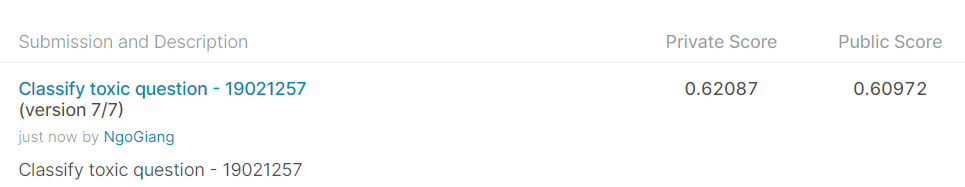